# 1D Wave Equation Inversion Using PINNs (3-layer Velocity Medium)
The goal of this notebook is to use **Physics-Informed Neural Nets (PINNs)** to:
1. Predict the seismic wavefield generated some given initial conditions in a 1D acoustic isotropic medium with composed of two layers separated by a sharp interface
2. Recover the **velocity value** in the domain of interest

## PINN
- We create two neural nets $N_1$ and $N_2$. 
    - $N_1$ takes into input the position $x$, the time $t$. The output is the acoustic pressure $p(x,t)$ at this location/time: $N_1: \; x,t \mapsto p(x,t)$
    - $N_2$ takes into input the position $x$, and returns a predicted velocity value: $N_2: \; x \mapsto v(x)$
- The 1D modeling domain, time interval, boundary and initial conditions are identical to the previous 1D examples. 
- For the training stage, we add **five constraints**:
    - Two initial conditions on the pressure field itself and on its time derivative
    - One boundary condition
    - One constraint enforcing the pressure field to satisfy the wave-equation inside the 1D modeling domain 
    - We add a data constraint to our loss function to improve the training efficiency. To do so, we generate and sample pressure data using a FD scheme
- In additional constraint can be used to incorporate prior information about the velocity model (two-layer model) by adding a term to our loss function enforces the **spatial derivative of the velocity field to vanish** in each layer

## Workflow Description
1. Pressure data generation using a FD scheme
2. Pressure field prediction and velocity estimation. We compare the pressure field predicted by the PINN with the one from the FD scheme

## 1. Generate a Pressure Dataset
In this section, we generate a dataset using a FD scheme

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#### Generate data with FD and the "true" velocity value ####
# Sampling
dx = 0.01
dt = 0.001

# Boundaries
L = float(np.pi)
x0 = 0
x1 = np.pi
t0 = 0
t1 = 2*np.pi
fmax = 1.0/(2*np.pi)
s = dt*dt/(dx*dx)

# Generate 1D mesh
x_fd = np.arange(x0, x1, dx)
t_fd = np.arange(t0, t1, dt)
nx_fd = x_fd.shape[0]
nt_fd = t_fd.shape[0]

# Generate 3-layer velocity
v_fd_true = np.zeros((nx_fd))
v_fd_true[:nx_fd//3] = 1.0
v_fd_true[nx_fd//3:int(nx_fd*2/3)] = 1.5
v_fd_true[int(nx_fd*2/3):] = 2.0

# FD stability/dispersion
courant = v_fd_true.max()*dt/dx
disp = v_fd_true.min()/(dt*fmax)
print("Courant:" , courant)
print("Dispersion:" , disp)

## Finite-difference solution
u_fd1 = np.zeros((nt_fd, nx_fd))
t_fd_save = np.zeros((nt_fd, nx_fd))
x_fd_save = np.zeros((nt_fd, nx_fd))

# Initial conditions
u_fd1[0,:] = np.sin(x_fd)
u_fd1[1,:] = np.sin(x_fd)*(dt+1)

# Fill x_fd and t_fd values
for it in range(0, nt_fd, 1):
    for ix in range(0, nx_fd, 1):    
        t_fd_save[it,ix] = t_fd[it]
        x_fd_save[it,ix] = x_fd[ix]

for it in range(2,nt_fd,1):
    for ix in range(2,nx_fd-1,1):
        u_fd1[it,ix] = 2*(1-s*v_fd_true[ix]*v_fd_true[ix])*u_fd1[it-1,ix] - u_fd1[it-2,ix] + s*v_fd_true[ix]*v_fd_true[ix]*(u_fd1[it-1,ix+1]+u_fd1[it-1,ix-1])
        
# Subsample FD solution
u_fd_sub = u_fd1[0::40,0::4]
x_fd_sub = x_fd[0::4]
t_fd_sub = t_fd[0::40]
v_true_sub = v_fd_true[0::4]

print("--- Done ---")

Courant: 0.2
Dispersion: 6283.185307179586
--- Done ---


In [3]:
# Interface positions
idx0 = 0
idx1 = int(nx_fd//3)
idx2 = int(nx_fd*2/3)
idx3 = nx_fd-1
x_interface0 = x_fd[0]
x_interface1 = x_fd[idx1]
x_interface2 = x_fd[idx2]
x_interface3 = x_fd[idx3]

# Layer 0
print("-"*20)
print("[L0] x_min: ", x_fd[0])
print("[L0] x_max: ", x_fd[idx1-1])
print("[L0] vel: ", v_fd_true[0])
print("-"*20)

# Layer 1
print("[L1] x_min: ", x_fd[idx1])
print("[L1] x_max: ", x_fd[idx2-1])
print("[L1] vel: ", v_fd_true[idx1])
print("-"*20)

# Layer 2
print("[L2] x_min: ", x_fd[idx2])
print("[L2] x_max: ", x_fd[nx_fd-1])
print("[L2] vel: ", v_fd_true[idx2])
print("-"*20)

--------------------
[L0] x_min:  0.0
[L0] x_max:  1.04
[L0] vel:  1.0
--------------------
[L1] x_min:  1.05
[L1] x_max:  2.09
[L1] vel:  1.5
--------------------
[L2] x_min:  2.1
[L2] x_max:  3.14
[L2] vel:  2.0
--------------------


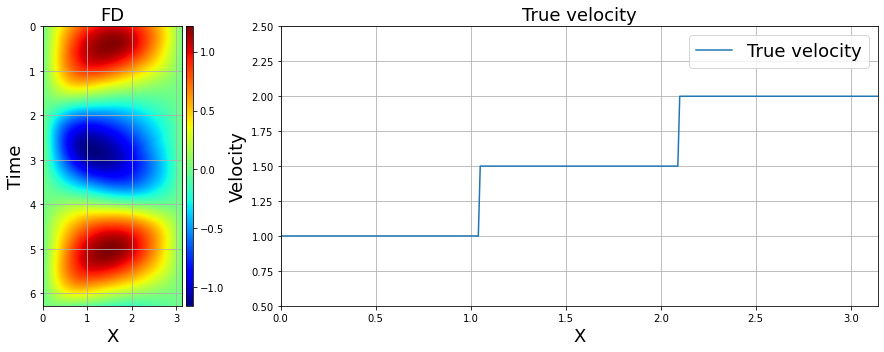

In [4]:
#### Plot results for QC ####
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('legend', fontsize=18)

# FD solution
img0 = axs[0].imshow(u_fd1, cmap='jet', vmin=u_fd1.min(), vmax=u_fd1.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Time', fontsize=18)
axs[0].set_title('FD', fontsize=18)
axs[0].grid()
plt.tight_layout()

# Velocity profile
img1 = axs[1].plot(x_fd, v_fd_true, label="True velocity")
plt.tight_layout()
axs[1].grid()
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Velocity', fontsize=18)
axs[1].set_title('True velocity', fontsize=18)
axs[1].set_xlim([0, np.pi])
axs[1].set_ylim([0.5, 2.5])
axs[1].legend()


In [5]:
# Save data 
import os
import h5py

sub_t = 100
sub_x = 10
x_fd_save_sub = x_fd_save[::sub_t,::sub_x]
t_fd_save_sub = t_fd_save[::sub_t,::sub_x]
u_fd1_sub = u_fd1[::sub_t,::sub_x]

nt_data = x_fd_save_sub.shape[0]
nx_data = x_fd_save_sub.shape[1]

# QC
# print("x_fd_save_sub: ", x_fd_save_sub[0,:])
# print("t_fd_save_sub: ",t_fd_save_sub[:,0])
# print("u_fd1_sub: ", u_fd1_sub.shape)

data_fd = {}
data_fd['x'] = x_fd_save_sub.reshape(-1,1)
data_fd['t'] = t_fd_save_sub.reshape(-1,1)
data_fd['u'] = u_fd1_sub.reshape(-1,1)

# Save pressure data
filename=f"data_fd_resampled-subx{sub_x}-subt{sub_t}.hdf5"
with h5py.File(os.getcwd()+"/"+filename, "w") as f:
    for k, p in data_fd.items():
        f.create_dataset(k, data = p)  
print(filename)

data_fd_resampled-subx10-subt100.hdf5


In [6]:
# Save data
import h5py

samp=1000
data_fd = {}
data_fd['x'] = x_fd_save.reshape(-1,1)[::samp]
data_fd['t'] = t_fd_save.reshape(-1,1)[::samp]
data_fd['u'] = u_fd1.reshape(-1,1)[::samp]

# QC
# print("shape data_fd: ", data_fd['x'][::samp].shape)
# print("x_fd_save: ", x_fd_save[0,:])
# print("t_fd_save: ", t_fd_save[:,0])

filename=f"data_fd_resampled-{samp}.hdf5"
with h5py.File("/mount/workspace_test/temp/mtc-repo/examples/we-inv-1d-vel-3layers/"+filename, "w") as f:
    for k,v in data_fd.items():
        f.create_dataset(k, data = v)  
print(filename)

data_fd_resampled-1000.hdf5


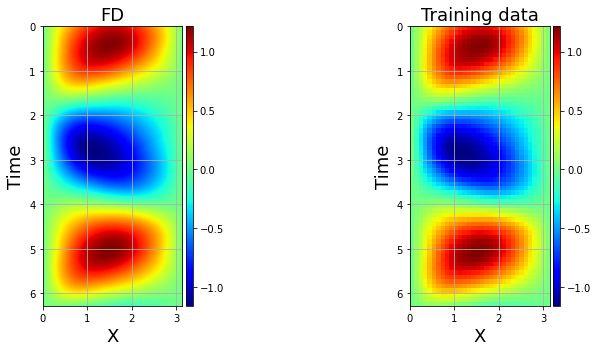

In [7]:
################## Load and plot training data ##################
import h5py
hdf_fname="/mount/workspace_test/temp/mtc-repo/examples/we-inv-1d-vel-3layers/data_fd_resampled-subx10-subt100.hdf5"
f = h5py.File(hdf_fname, "r")
x_data = np.reshape(f['x'],(nt_data, nx_data))
t_data = np.reshape(f['t'],(nt_data, nx_data))
u_data = np.reshape(f['u'],(nt_data, nx_data))

# print("u_data shape: ", u_data.shape)

#### Plot results for QC #### 
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# FD solution
img0 = axs[0].imshow(u_fd1, cmap='jet', vmin=u_fd1.min(), vmax=u_fd1.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Time', fontsize=18)
axs[0].set_title('FD', fontsize=18)
axs[0].grid()
plt.tight_layout()

# Display data used for training
# FD solution
img0 = axs[1].imshow(u_data, cmap='jet', vmin=u_fd1.min(), vmax=u_fd1.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Time', fontsize=18)
axs[1].set_title('Training data', fontsize=18)
axs[1].grid()
plt.tight_layout()


## 2. PINN solution
- Pressure prediction
- Velocity estimation

In [8]:
# Import modules
import training.stage3.infer as infer_stage1

# Display information on inferencer
infer_stage1.info

# Use inferencer on the data used for training
u1 = infer_stage1.infer(x=x_fd_save_sub, t=t_fd_save_sub)['u']
u1 = u1.reshape(x_fd_save_sub.shape)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/modulus/modulus/dataset/dataset.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:200.)
  key: torch.as_tensor(value, dtype=tf_dt, device=device)


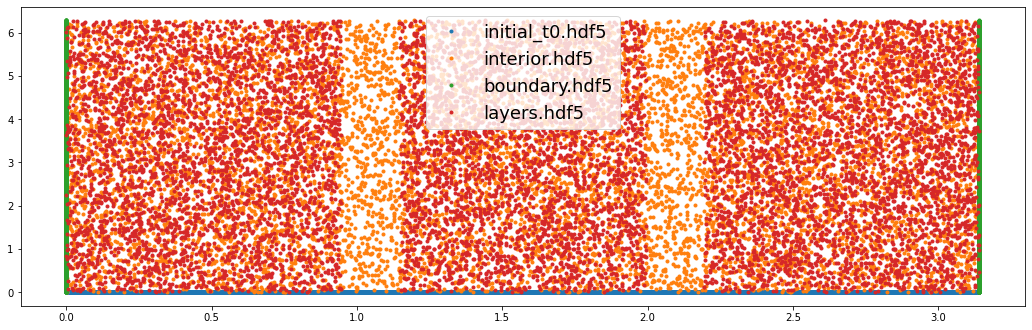

In [9]:
# Plot sampled points for training
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

dpath = 'training/stage1/samples/'
n=10000 # number of points from each sub-domain
dd={}
for fname in reversed(os.listdir(dpath)):
    with h5py.File(dpath+fname) as f:
        idx=np.random.choice(np.arange(f['x'].shape[0]), size=n)
        idx=np.sort(idx)
        plt.plot(f['x'][:][idx], f['t'][:][idx], '.', label=fname)
        dd[fname] = {k:f[k][:] for k in f.keys()}
        
plt.legend()

# Save figure
plt.savefig("we-inv-1d-vel-3layers-deriv-sample.png")

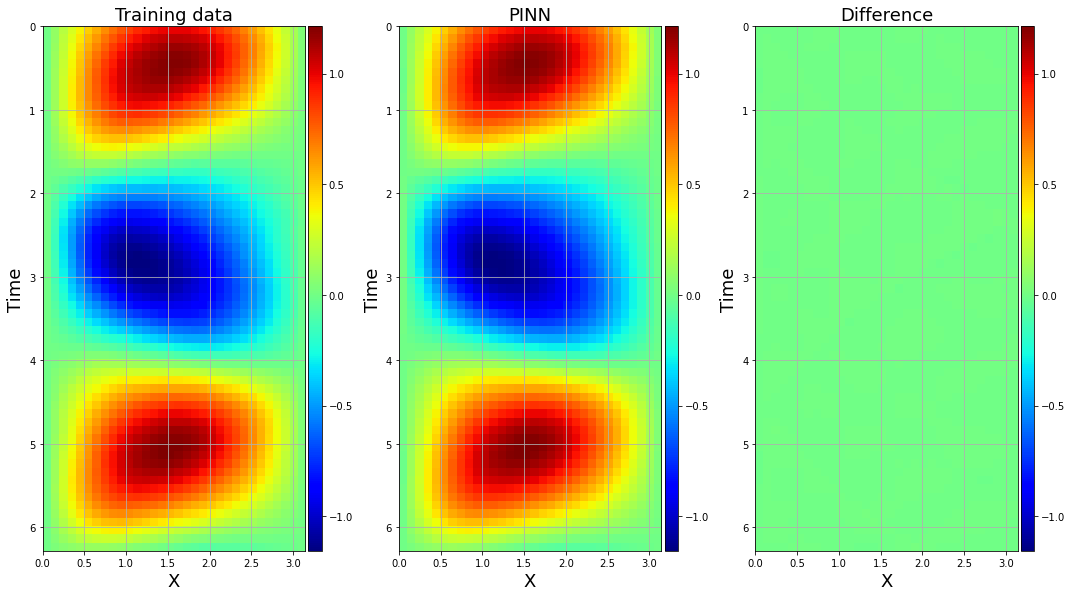

In [10]:
################## Plotting ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 15))

# FD solution
img0 = axs[0].imshow(u_data, cmap='jet', vmin=u_fd1.min(), vmax=u_fd1.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Time', fontsize=18)
axs[0].set_title('Training data', fontsize=18)
axs[0].grid()
plt.tight_layout()

# PINN 1 solution
img1 = axs[1].imshow(u1, cmap='jet', vmin=u_fd1.min(), vmax=u_fd1.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img1, cax=cax)
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Time', fontsize=18)
axs[1].set_title('PINN', fontsize=18)
axs[1].grid()
plt.tight_layout()

# PINN 1 data misfit 
img1 = axs[2].imshow(u1-u_data, cmap='jet', vmin=u_fd1.min(), vmax=u_fd1.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img1, cax=cax)
axs[2].set_xlabel('X', fontsize=18)
axs[2].set_ylabel('Time', fontsize=18)
axs[2].set_title('Difference', fontsize=18)
axs[2].grid()
plt.tight_layout()


In [11]:
################## PINN solution ##################
L = float(np.pi)
x = np.arange(0, L, 0.04)
t = np.arange(0, 2*L, 0.04)
k = np.arange(1, 10, 1)
nx = x.shape[0]
nt = t.shape[0]
X, T = np.meshgrid(x, t)

# Predicted solutions
u1 = infer_stage1.infer(x=X, t=T)['u']
v1 = infer_stage1.infer(x=X, t=T)['vel']
u1 = u1.reshape(X.shape)
v1 = v1.reshape(X.shape)

V_fd shape:  (158, 79)
v1.min:  0.99994427
v1.max:  1.970331


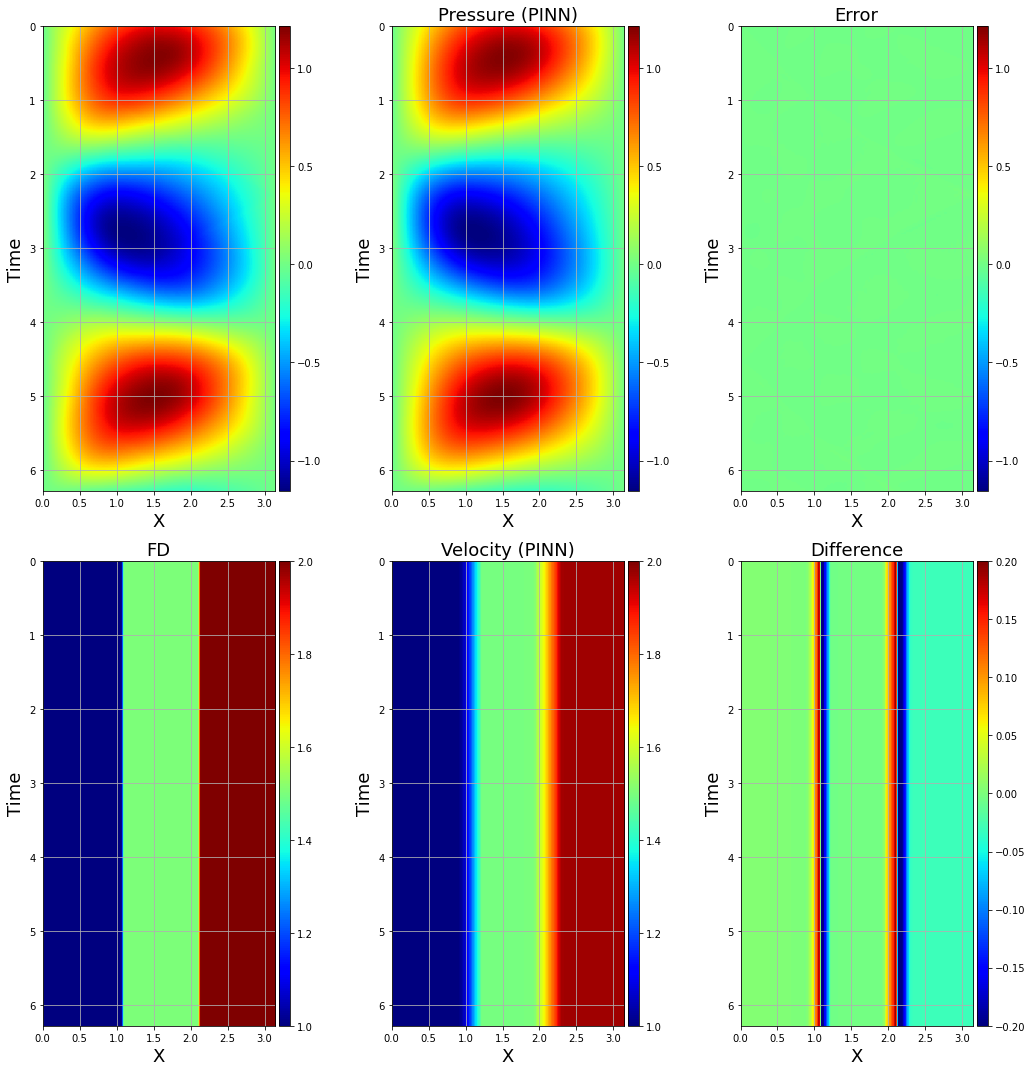

In [12]:
################## Plotting ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(2, 3, figsize=(15, 15))

# FD solution
img0 = axs[0,0].imshow(u_fd_sub, cmap='jet', vmin=u_fd1.min(), vmax=u_fd1.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img0, cax=cax)
axs[0,0].set_xlabel('X', fontsize=18)
axs[0,0].set_ylabel('Time', fontsize=18)
axs[0,1].set_title('Pressure (FD)', fontsize=18)
axs[0,0].grid()
plt.tight_layout()

# PINN 1 solution
img1 = axs[0,1].imshow(u1, cmap='jet', vmin=u_fd1.min(), vmax=u_fd1.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img1, cax=cax)
axs[0,1].set_xlabel('X', fontsize=18)
axs[0,1].set_ylabel('Time', fontsize=18)
axs[0,1].set_title('Pressure (PINN)', fontsize=18)
axs[0,1].grid()
plt.tight_layout()

# PINN 1 difference
img1 = axs[0,2].imshow(u1-u_fd_sub, cmap='jet', vmin=u_fd1.min(), vmax=u_fd1.max(), extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img1, cax=cax)
axs[0,2].set_xlabel('X', fontsize=18)
axs[0,2].set_ylabel('Time', fontsize=18)
axs[0,2].set_title('Error', fontsize=18)
axs[0,2].grid()
plt.tight_layout()

# True velocity
X_fd, T_fd = np.meshgrid(x_fd_sub, t_fd_sub)
V_fd = X_fd*0 + v_true_sub
print("V_fd shape: ", V_fd.shape)
img2 = axs[1,0].imshow(V_fd, cmap='jet', vmin=1.0, vmax=2.0, extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img2, cax=cax)
axs[1,0].set_xlabel('X', fontsize=18)
axs[1,0].set_ylabel('Time', fontsize=18)
axs[1,0].set_title('FD', fontsize=18)
axs[1,0].grid()
plt.tight_layout()

# PINN
print("v1.min: ", v1.min())
print("v1.max: ", v1.max())
img3 = axs[1,1].imshow(abs(v1), cmap='jet', vmin=1.0, vmax=2.0, extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img3, cax=cax)
axs[1,1].set_xlabel('X', fontsize=18)
axs[1,1].set_ylabel('Time', fontsize=18)
axs[1,1].set_title('Velocity (PINN)', fontsize=18)
axs[1,1].grid()
plt.tight_layout()

# PINN
img3 = axs[1,2].imshow(abs(v1)-V_fd, cmap='jet', vmin=-0.2, vmax=0.2, extent=(0, L, 2*L, 0))
divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img3, cax=cax)
axs[1,2].set_xlabel('X', fontsize=18)
axs[1,2].set_ylabel('Time', fontsize=18)
axs[1,2].set_title('Difference', fontsize=18)
axs[1,2].grid()
plt.tight_layout()

# Save figure
plt.savefig("we-inv-1d-vel-3layers-deriv.png")

time:  0.0
nt:  158


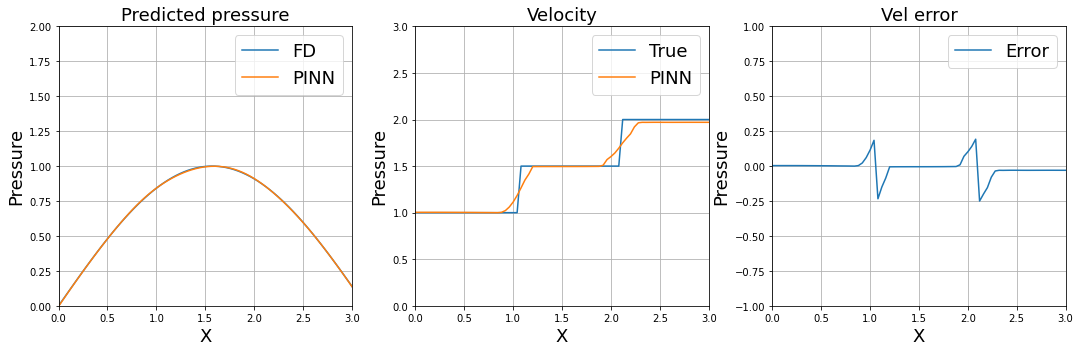

In [13]:
####### 1D plots at constant time #######
itime = 0 # Time 
print("time: ", t[itime]) 
print("nt: ", nt)

p_fd = u_fd1[itime,:] # FD solution
p1 = u1[itime,:]

v1_time = v1[itime,:] 
v_fd_time = 0.0*v1_time + v_true_sub

################## Plotting ##################
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

# Create figures and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.rc('legend', fontsize=18)
    
# FD/PINN solution
img1 = axs[0].plot(x, u_fd_sub[itime,:], label="FD")
img1 = axs[0].plot(x, p1, label="PINN")
plt.tight_layout()
axs[0].grid()
axs[0].set_xlabel('X', fontsize=18)
axs[0].set_ylabel('Pressure', fontsize=18)
axs[0].set_title('Predicted pressure', fontsize=18)
axs[0].set_xlim([0, 3.0])
axs[0].set_ylim([0, 2])
axs[0].legend()

# PINN solution
img2 = axs[1].plot(x, v_fd_time, label="True")
img2 = axs[1].plot(x, abs(v1_time), label="PINN")
plt.tight_layout()
axs[1].grid()
axs[1].set_xlabel('X', fontsize=18)
axs[1].set_ylabel('Pressure', fontsize=18)
axs[1].set_title('Velocity', fontsize=18)
axs[1].set_xlim([0, 3.0])
axs[1].set_ylim([0, 3.0])
axs[1].legend()

# Error solution
img2 = axs[2].plot(x, abs(v1_time)- v_fd_time, label="Error")
plt.tight_layout()
axs[2].grid()
axs[2].set_xlabel('X', fontsize=18)
axs[2].set_ylabel('Pressure', fontsize=18)
axs[2].set_title('Vel error', fontsize=18)
axs[2].set_xlim([0, 3.0])
axs[2].set_ylim([-1.0, 1.0])
axs[2].legend()

# Save figure
plt.savefig("we-inv-1d-vel-3layers-profilex-deriv.png")